In [1]:
import pickle
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy import stats
import scipy.stats as scs
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# функция для преобразования Бокса-Кокса
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [0]:
# прочесть данные
with open('/content/gdrive/My Drive/DATA/Stepik/agg_statistic2016.pkl', 'rb') as f:
    data = pickle.load(f)

### 1. Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. Не используйте данные за последний имеющийся месяц — июнь 2016! Создайте регрессионные признаки для учёта сезонностей и трендов.

In [0]:
# выбрал зону с максимальным количеством поездок
data = data.iloc[1282, :]

In [0]:
data = pd.DataFrame(data)
data.columns = ["count_trip"]

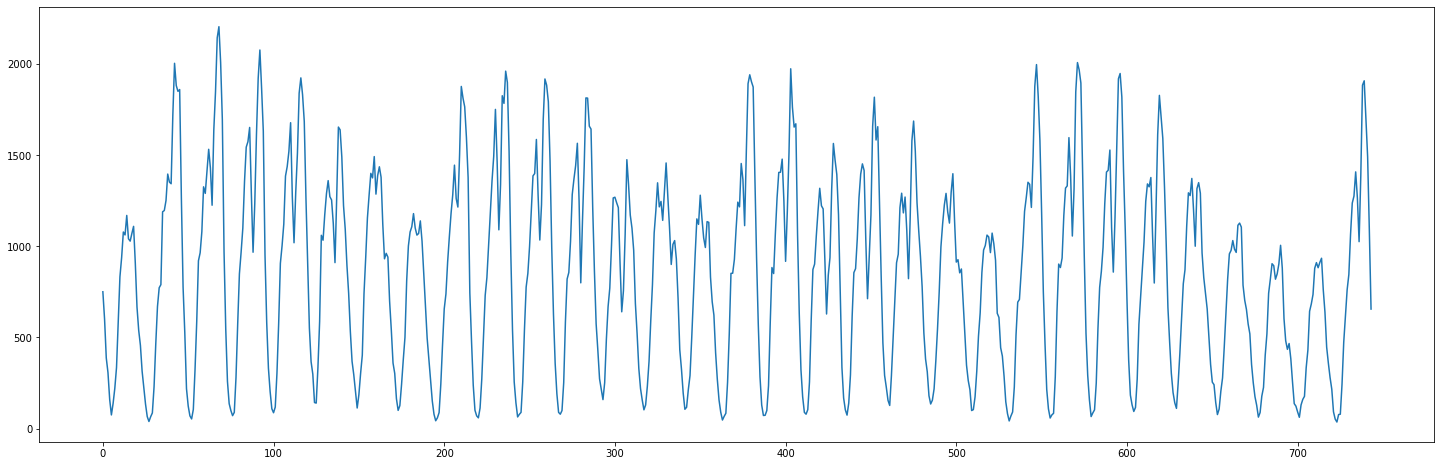

In [7]:
plt.figure(figsize=(25, 8))
data.count_trip.plot()
plt.show()

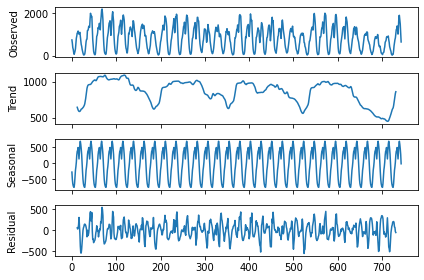

In [8]:
#plt.figure(figsize=(25, 8))
sm.tsa.seasonal_decompose(data.count_trip, freq=24).plot();

### 2. Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.

In [9]:
# создаю регриссионные признаки из прошлого задания
mse_list = []
K = 70
for number in range (1, K+1):
    ols_data = data.copy()
    for i in range(1, number+1):        
        ols_data['s_'+str(i)] = np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)
        ols_data['c_'+str(i)] = np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)
    y = ols_data.count_trip
    X = ols_data.loc[:, 's_1':]
    model = LinearRegression()
    res = model.fit(X, y)
    mse_list.append(mean_squared_error(y, res.predict(X)))
    K_opt = np.argmin(mse_list)
print ('Минимальное квадратичное отклонение достигнуто при K =', K_opt)

Минимальное квадратичное отклонение достигнуто при K = 69


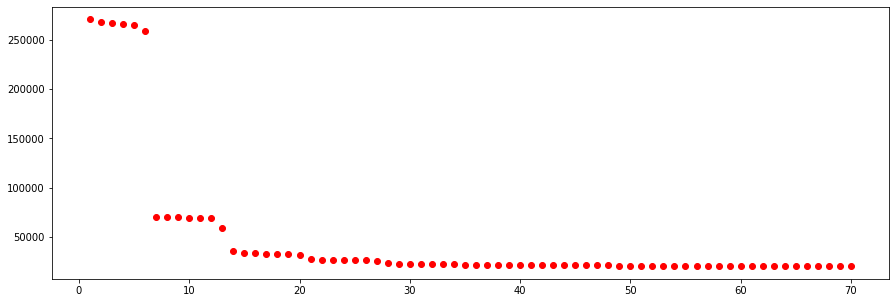

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(np.arange(1, K+1), mse_list, 'ro')

In [0]:
K_opt = 30

In [0]:
for i in range(1, K_opt+1):        
        data['s_'+str(i)] = np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)
        data['c_'+str(i)] = np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)

In [13]:
data.head()

,count_trip,s_1,c_1,s_2,c_2,s_3,c_3,s_4,c_4,s_5,c_5,s_6,c_6,s_7,c_7,s_8,c_8,s_9,c_9,s_10,c_10,s_11,c_11,s_12,c_12,s_13,c_13,s_14,c_14,s_15,c_15,s_16,c_16,s_17,c_17,s_18,c_18,s_19,c_19,s_20,c_20,s_21,c_21,s_22,c_22,s_23,c_23,s_24,c_24,s_25,c_25,s_26,c_26,s_27,c_27,s_28,c_28,s_29,c_29,s_30,c_30
0,751.0,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,0.222521,0.974928,0.258819,0.965926,0.294755,0.955573,0.330279,0.943883,0.365341,0.930874,0.399892,0.916562,0.433884,0.900969,0.467269,0.884115,0.500000,8.660254e-01,0.532032,0.846724,0.563320,0.826239,0.593820,0.804598,0.623490,0.781831,0.652287,0.757972,0.680173,0.733052,7.071068e-01,7.071068e-01,0.733052,0.680173,0.757972,0.652287,0.781831,0.623490,0.804598,0.593820,0.826239,0.563320,0.846724,0.532032,8.660254e-01,0.5,0.884115,0.467269,0.900969,0.433884
1,601.0,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,0.433884,0.900969,0.500000,0.866025,0.563320,0.826239,0.623490,0.781831,0.680173,0.733052,0.733052,0.680173,0.781831,0.623490,0.826239,0.563320,0.866025,5.000000e-01,0.900969,0.433884,0.930874,0.365341,0.955573,0.294755,0.974928,0.222521,0.988831,0.149042,0.997204,0.074730,1.000000e+00,6.123234e-17,0.997204,-0.074730,0.988831,-0.149042,0.974928,-0.222521,0.955573,-0.294755,0.930874,-0.365341,0.900969,-0.433884,8.660254e-01,-0.5,0.826239,-0.563320,0.781831,-0.623490
2,388.0,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724,0.623490,0.781831,0.707107,0.707107,0.781831,0.623490,0.846724,0.532032,0.900969,0.433884,0.943883,0.330279,0.974928,0.222521,0.993712,0.111964,1.000000,6.123234e-17,0.993712,-0.111964,0.974928,-0.222521,0.943883,-0.330279,0.900969,-0.433884,0.846724,-0.532032,0.781831,-0.623490,7.071068e-01,-7.071068e-01,0.623490,-0.781831,0.532032,-0.846724,0.433884,-0.900969,0.330279,-0.943883,0.222521,-0.974928,0.111964,-0.993712,1.224647e-16,-1.0,-0.111964,-0.993712,-0.222521,-0.974928
3,307.0,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052,0.781831,0.623490,0.866025,0.500000,0.930874,0.365341,0.974928,0.222521,0.997204,0.074730,0.997204,-0.074730,0.974928,-0.222521,0.930874,-0.365341,0.866025,-5.000000e-01,0.781831,-0.623490,0.680173,-0.733052,0.563320,-0.826239,0.433884,-0.900969,0.294755,-0.955573,0.149042,-0.988831,1.224647e-16,-1.000000e+00,-0.149042,-0.988831,-0.294755,-0.955573,-0.433884,-0.900969,-0.563320,-0.826239,-0.680173,-0.733052,-0.781831,-0.623490,-8.660254e-01,-0.5,-0.930874,-0.365341,-0.974928,-0.222521
4,160.0,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820,0.900969,0.433884,0.965926,0.258819,0.997204,0.074730,0.993712,-0.111964,0.955573,-0.294755,0.884115,-0.467269,0.781831,-0.623490,0.652287,-0.757972,0.500000,-8.660254e-01,0.330279,-0.943883,0.149042,-0.988831,-0.037391,-0.999301,-0.222521,-0.974928,-0.399892,-0.916562,-0.563320,-0.826239,-7.071068e-01,-7.071068e-01,-0.826239,-0.563320,-0.916562,-0.399892,-0.974928,-0.222521,-0.999301,-0.037391,-0.988831,0.149042,-0.943883,0.330279,-8.660254e-01,0.5,-0.757972,0.652287,-0.623490,0.781831


In [0]:
y = ols_data.count_trip
X_opt = ols_data.loc[:, 's_1':]

model = LinearRegression()
res = model.fit(X_opt, y)
y_pred = res.predict(X_opt)

data['l_prediction'] = y_pred
data['error'] = y - y_pred

In [15]:
print ('Коэффициент детерминации модели:', res.score(X_opt, y))

Коэффициент детерминации модели: 0.9318461224005696


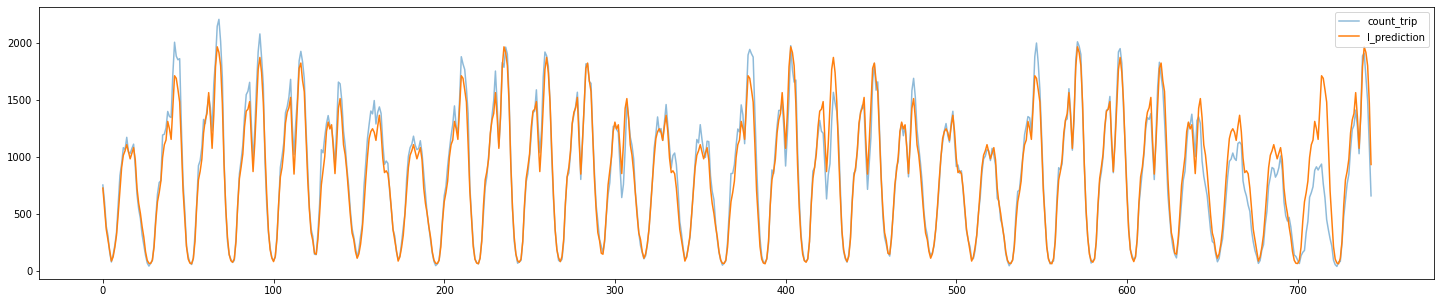

In [17]:
plt.figure(figsize=(25,5))
data['count_trip'].plot(alpha = 0.5, legend = True)
data['l_prediction'].plot(legend = True)

### 3. Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

<Figure size 1080x720 with 0 Axes>

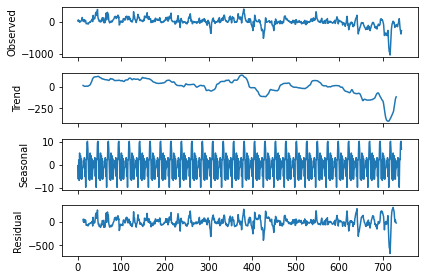

In [18]:
plt.figure(figsize = (15, 10))
sm.tsa.seasonal_decompose(data['error'], freq = 24).plot();

In [19]:
print('Значение критерия Дики-Фуллера для исходного ряда:', sm.tsa.stattools.adfuller(data['count_trip'])[1])

Значение критерия Дики-Фуллера для исходного ряда: 0.030542546199399223


**Критерий нам говорит, что гипотезу нестационарности можно отвергнуть. Будем считать ряд стационарным**

### 4. Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров (p, q, P, Q)(p,q,P,Q). Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.

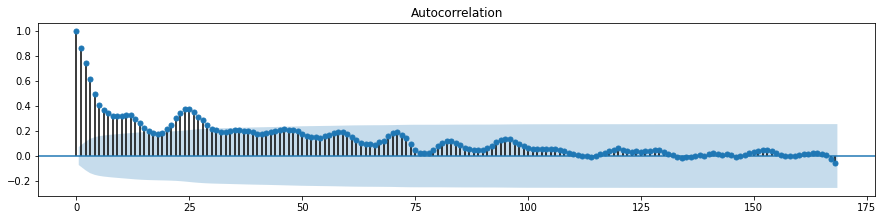

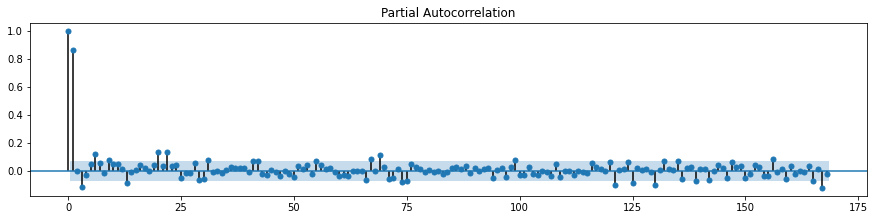

In [20]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['error'].dropna().values.squeeze(), lags = 168, ax = ax)
plt.show()
plt.figure(figsize=(15,7))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['error'].dropna().values.squeeze(), lags = 168, ax = ax)
plt.show()

Выбранные значения параметров: Q = 1 q = 15 P = 1 p = 2

In [0]:
ps = range(0, 3)
d = 0
qs = range(0, 16)
Ps = range(0, 2)
D = 0
Qs = range(0, 2)

In [22]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

len(parameters_list)

192

In [23]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore') #отключим предупрежедения, так как не все модели, которые мы получим в процессе перебора, 
                                  #будут сходящимися
for param in parameters_list:     
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.count_trip, 
                                        exog = data[data.columns[1:-2]], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue

    except LinAlgError:
        print('singularity parameters:', param)
        continue

    aic = model.aic
    print ('parameters:{} have aic value {}'.format(param, aic))
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

parameters:(0, 0, 0, 0) have aic value 12305.701813123702
parameters:(0, 0, 0, 1) have aic value 11629.00109115421
parameters:(0, 0, 1, 0) have aic value 10026.471825582086
parameters:(0, 0, 1, 1) have aic value 9592.4187539108
parameters:(0, 1, 0, 0) have aic value 11383.566595350114
parameters:(0, 1, 0, 1) have aic value 10820.168403596268
parameters:(0, 1, 1, 0) have aic value 9938.042365029074
parameters:(0, 1, 1, 1) have aic value 9260.296204338794
parameters:(0, 2, 0, 0) have aic value 10746.296280307995
parameters:(0, 2, 0, 1) have aic value 11150.890780140304
parameters:(0, 2, 1, 0) have aic value 9875.025191791767
parameters:(0, 2, 1, 1) have aic value 10746.862005168998
parameters:(0, 3, 0, 0) have aic value 10862.682818983752
parameters:(0, 3, 0, 1) have aic value 10984.5861544841
parameters:(0, 3, 1, 0) have aic value 9711.14653788822
parameters:(0, 3, 1, 1) have aic value 9598.936550437556
parameters:(0, 4, 0, 0) have aic value 11266.166996833006
parameters:(0, 4, 0, 1) ha

### 5. Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов (K)(K) или поменять порядки дифференцирования. 

In [24]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

        parameters          aic
127  (1, 15, 1, 1)  8950.776645
191  (2, 15, 1, 1)  8951.610119
123  (1, 14, 1, 1)  8954.526960
115  (1, 12, 1, 1)  8959.213397
119  (1, 13, 1, 1)  8959.590448


In [25]:
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                          count_trip   No. Observations:                  744
Model:             SARIMAX(1, 0, 15)x(1, 0, 1, 12)   Log Likelihood               -4396.388
Date:                             Thu, 11 Jun 2020   AIC                           8950.777
Time:                                     18:23:05   BIC                           9315.128
Sample:                                          0   HQIC                          9091.222
                                             - 744                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s_1           50.6537     43.208      1.172      0.241     -34.033     135.340
c_1         -130.1312     4

Критерий Стьюдента: p=0.577977
Критерий Дики-Фуллера: p=0.000000


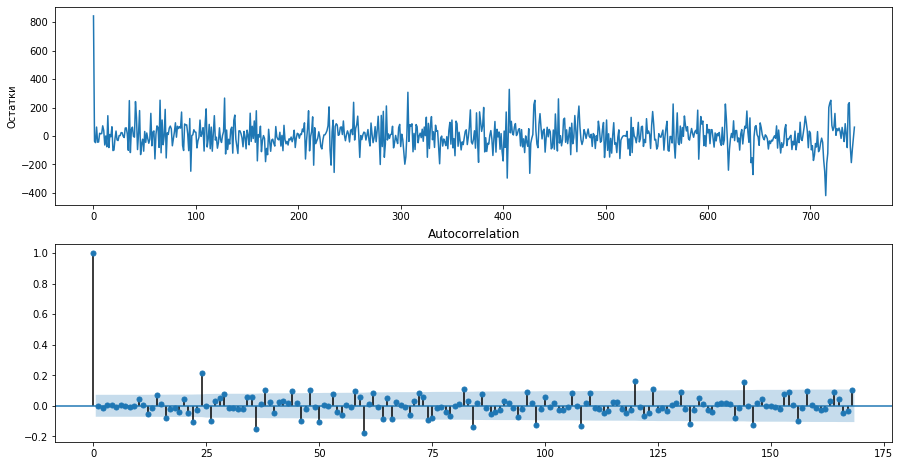

In [27]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Остатки')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

In [28]:
mean_resid = np.abs(best_model.resid.values.mean())
print (mean_resid)

1.9164021310802721


Критерий Стьюдента: p=0.026290
Критерий Дики-Фуллера: p=0.000000


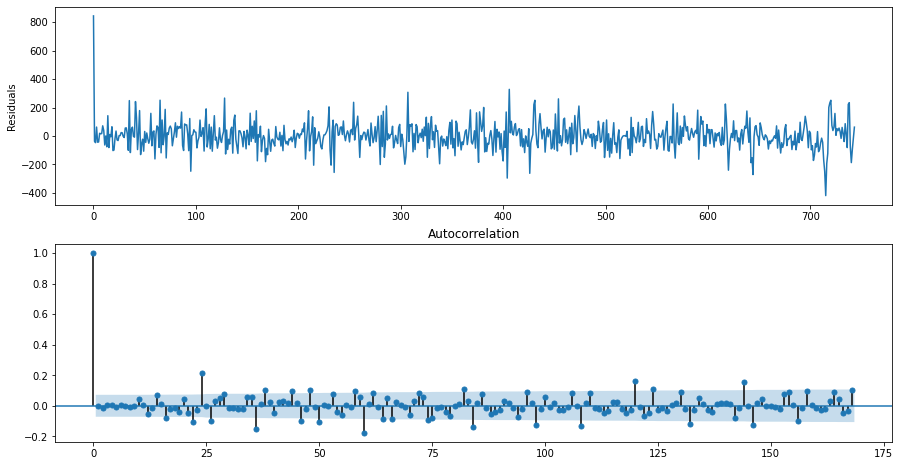

In [42]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze() + mean_resid , lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid + 3*mean_resid , 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid + 3*mean_resid)[1])

**Критерий Дики-Фуллера позволяет отклонить гипотезу о наличии автокоррелированности в остатках. Критерий Стьюдента позволяет считать модель несмещенной за счет корректировки.**

### 5. Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

In [0]:
data['model'] = best_model.fittedvalues + 3*mean_resid

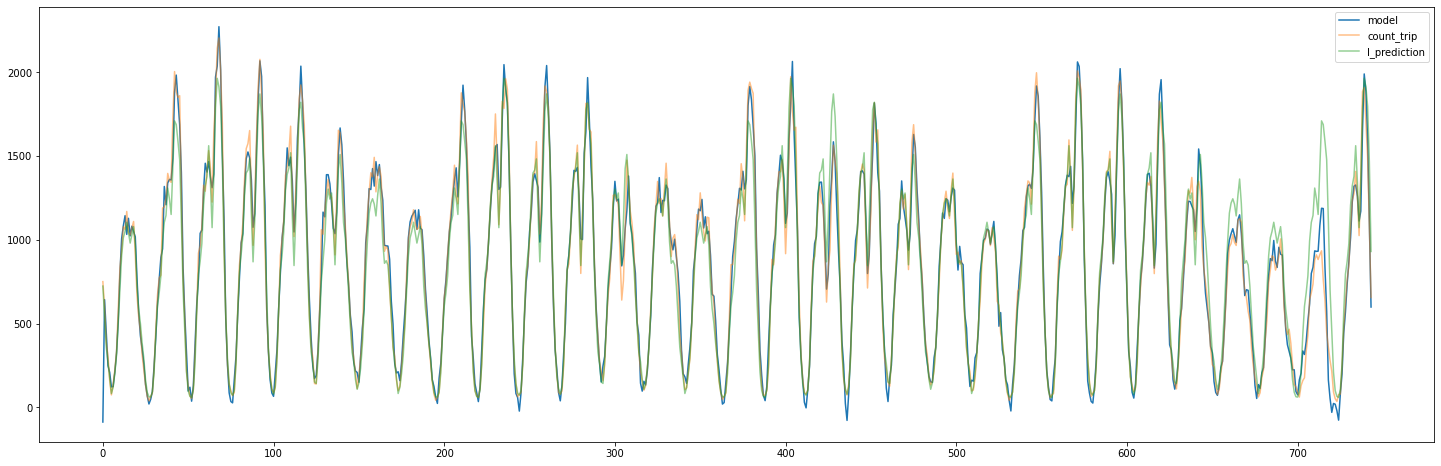

In [44]:
plt.figure(figsize=(25,8))
data['model'].plot(legend = True)
data['count_trip'].plot(legend = True, alpha = 0.5)
data['l_prediction'].plot(legend = True, alpha = 0.5)

**Модель точно предсказывает данные.**